<a href="https://colab.research.google.com/github/owoMarciN/Python/blob/main/Intro-AI/AI_Parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchvision
!pip install --upgrade ucimlrepo

In [47]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
#list_available_datasets()

# import dataset
park = fetch_ucirepo(id=174)

# access data
X = park.data.features
y = park.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
# print(park.metadata.uci_id)
# print(park.metadata.num_instances)
# print(park.metadata.additional_info.summary)

# access variable info in tabular format
# print(park.variables)

In [48]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [49]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [50]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
# Checking the data

# print(X.describe())
# print(y)

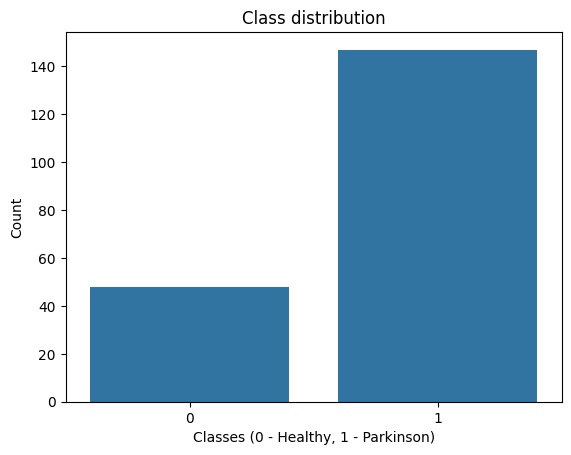

In [8]:
# Class distribution plot

sns.countplot(x=y['status'])
plt.title("Class distribution")
plt.xlabel("Classes (0 - Healthy, 1 - Parkinson)")
plt.ylabel("Count")
plt.show()

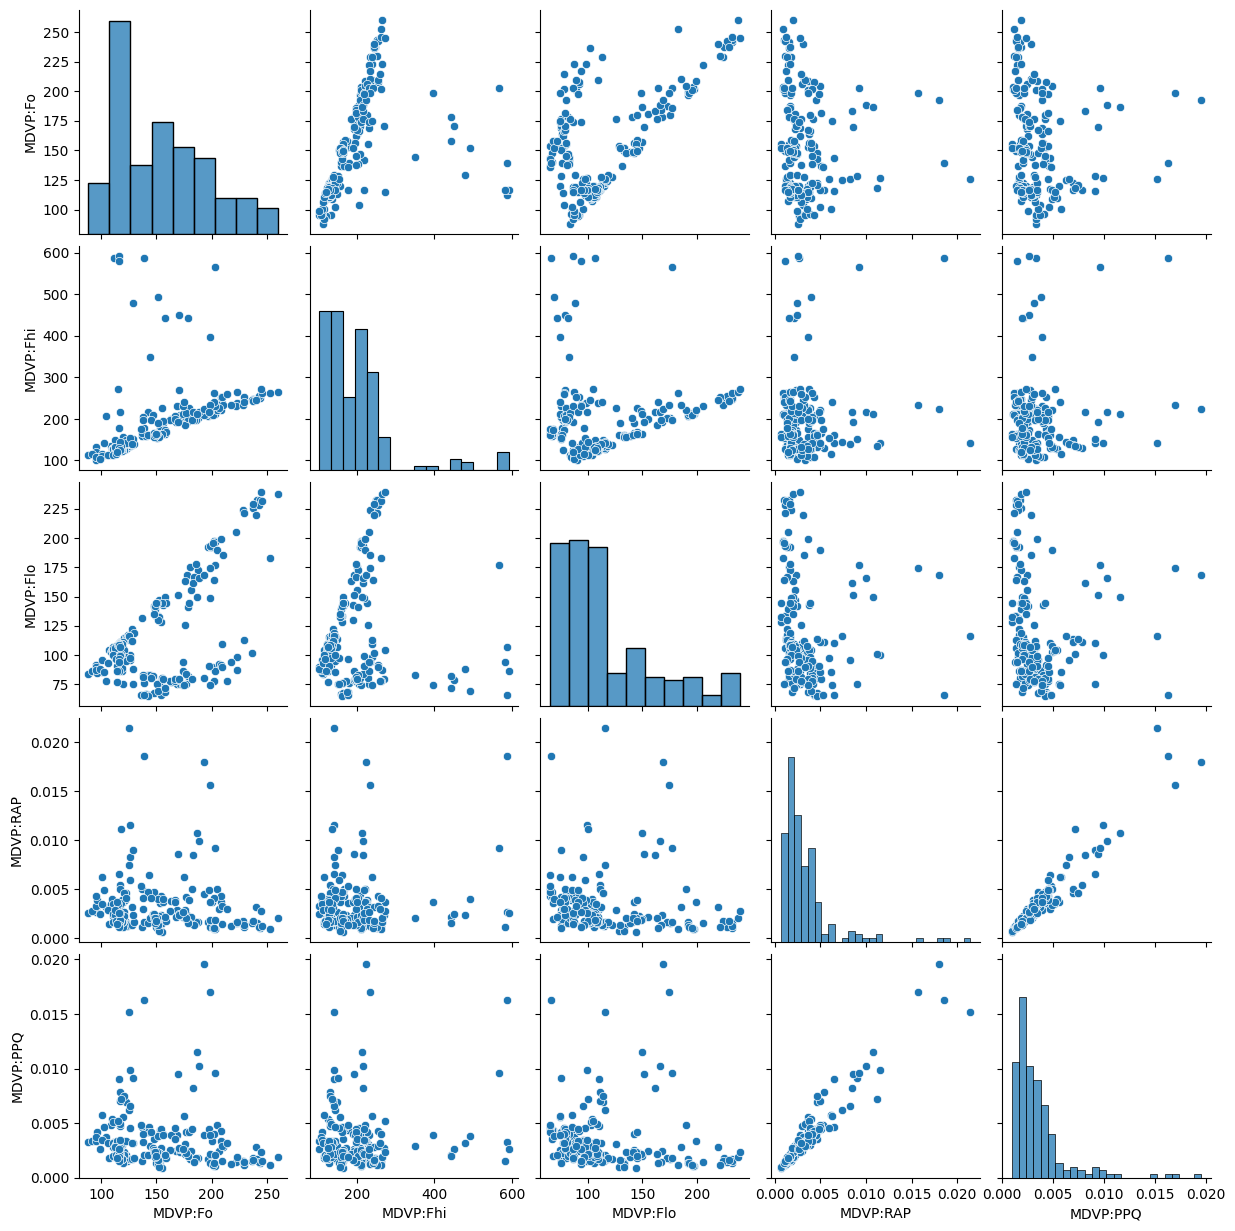

In [14]:
pp_data = X[['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:RAP', 'MDVP:PPQ']]

sns.pairplot(pp_data)
plt.show()

In [34]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum)
    if name == "adam":
        return optim.Adam(params, lr=lr)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum)
    raise ValueError("Unknown optimizer")

def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time

In [20]:
X = StandardScaler().fit_transform(X).astype('float32')
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

Xtr, Xte = map(torch.tensor, (Xtr, Xte))
ytr, yte = map (lambda v : torch.tensor(v.values).float(), (ytr, yte))

In [40]:
losses, metrics, elapsed_time = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
print(f"Baseline metrics (opt_name=Adam)\n {metrics}")
print(f"Elapsed time: {elapsed_time:.4f} seconds")

Baseline metrics (opt_name=Adam)
 {'acc': 0.9230769230769231, 'prec': 0.9333333333333333, 'rec': 0.9655172413793104, 'f1': 0.9491525423728814, 'auc': np.float64(0.9931034482758622)}
Elapsed time: 0.1820 seconds


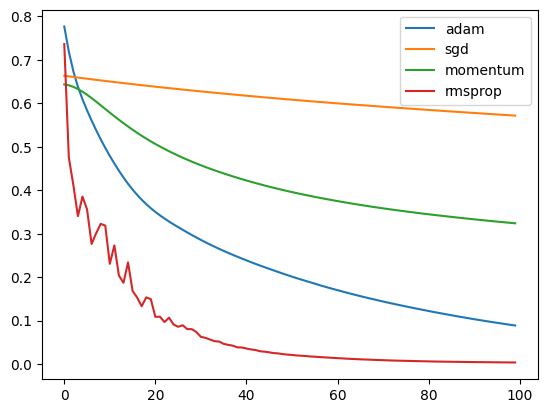

adam        acc=0.9744  f1=0.9831  time=0.1694s
sgd         acc=0.7949  f1=0.8750  time=0.0863s
momentum    acc=0.8718  f1=0.9206  time=0.0985s
rmsprop     acc=0.9744  f1=0.9831  time=0.1351s


In [46]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.savefig("lossfun.png")
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")

In [ ]:
def kmeans_features(X_train, X_test, n_clusters=8, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters,
    n_init=10,
    random_state=random_state)
    kmeans.fit(X_train)

    def to_dist(X):
        return np.linalg.norm(
            X[:, None, :] - kmeans.cluster_centers_[None, :, :],
            axis=2
            ).astype("float32")
    return to_dist(X_train), to_dist(X_test)

# Example usage in lab:
# Xtr_km, Xte_km = kmeans_features(X_train, X_test, n_clusters=8)
# Then call train_and_eval with in_dim = 8 and tensors from Xtr_km, Xte_km.

In [ ]:
Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=8)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

losses, metrics = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, in_dim=8)
metrics

In [ ]:
def pca_features(X_train, X_test, var_threshold=0.95, random_state=42):
    # PCA
    pca = PCA(n_components=var_threshold, random_state=random_state)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    print(f"We used {n_components} PCA components, to get ≥{int(var_threshold*100)}% variation.")

    return X_train_pca, X_test_pca, n_components

In [ ]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

losses, metrics = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, in_dim=n_components)
metrics

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        """Returns the 8-D bottleneck representation."""
        return self.encoder(x)


In [ ]:
def autoencoder_features(X_train, X_test, epochs=50, lr=1e-3):
    input_dim = X_train.shape[1]
    bottleneck_dim = 8

    ae = Autoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_tensor = X_train.float()

    # Training loop
    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(Xtr_tensor)
        loss = loss_fn(recon, Xtr_tensor)
        loss.backward()
        optimizer.step()

    # Extract 8-D features
    with torch.no_grad():
        Z_train = ae.encode(X_train.float())
        Z_test  = ae.encode(X_test.float())

    return Z_train, Z_test


In [ ]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

losses, metrics = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, in_dim=8)
metrics

In [ ]:
opt = ["adam", "sgd", "momentum", "rmsprop"]
all_metrics = []
all_losses = []

for opt_name in opt:
    Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=8)

    Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
    Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

    losses, metrics = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, in_dim=8)
    all_metrics.append(metrics)
    all_losses.append(losses)

    Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

    losses, metrics = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, in_dim=8)
    all_metrics.append(metrics)
    all_losses.append(losses)

    Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

    Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
    Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

    losses, metrics = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, in_dim=n_components)
    all_metrics.append(metrics)
    all_losses.append(losses)

In [ ]:
feature_names = ['KMeans', 'Autoencoder', 'PCA']
optimizers = ["adam", "sgd", "momentum", "rmsprop"]

metric_names = list(all_metrics[0].keys())  # e.g., ['acc', 'precision', 'recall', 'f1']

# Convert metrics to a structured array: optimizers x features x metrics
metrics_array = {metric: np.zeros((len(optimizers), len(feature_names))) for metric in metric_names}

for i, opt_name in enumerate(optimizers):
    for j, feat_name in enumerate(feature_names):
        idx = i*3 + j
        for metric in metric_names:
            metrics_array[metric][i, j] = all_metrics[idx][metric]

x = np.arange(len(optimizers))  # optimizer positions
width = 0.25

for metric in metric_names:
    plt.figure(figsize=(12,6))
    for j, feat_name in enumerate(feature_names):
        plt.bar(x + j*width, metrics_array[metric][:, j], width=width, label=feat_name)
    plt.xticks(x + width, optimizers)
    plt.ylabel(metric.upper())
    plt.title(f'{metric.upper()} Comparison Across Optimizers and Feature Sets')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')  # save figure
    plt.close()


# skip_idx # skip given index if needed
plt.figure(figsize=(16,10))
for i, opt_name in enumerate(optimizers):
    for j, feat_name in enumerate(feature_names):
        idx = i*3 + j
        # if idx == skip_idx:
        #     continue
        plt.plot(all_losses[idx], label=f'{opt_name} - {feat_name}')
plt.title('Training Loss per Optimizer and Feature Set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_comparison.png')
plt.close()

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import numpy as np

ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_pca)  # Xtr should be NumPy

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_pca_2d[ytr_np == label, 0], Xtr_pca_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)

plt.savefig("2D_PCA.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_ae_2d = pca_2d.fit_transform(Xtr_ae)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_ae_2d[ytr_np == label, 0], Xtr_ae_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D AE Projection")
plt.legend()
plt.grid(True)

# Save figure BEFORE showing it
plt.savefig("2D_AE.png", dpi=300, bbox_inches='tight')
plt.show()